### Кластеризация, внутренние метрики качества, PCA/t-SNE и "честный" unsupervised-эксперимент на синтетических данных ###

In [11]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [ ]:
metrics_summary = {}
best_configs = {}

def process_dataset(filename, dataset_name):
    print(f"\n{'='*40}\nProcessing {dataset_name}\n{'='*40}")
    
    # Загрузка
    file_path = os.path.join(os.getcwd(), "data", filename)
    
    if not os.path.exists(file_path):
        print(f"❌ ОШИБКА: Файл '{filename}' не найден в папке data!")
        return
        
    df = pd.read_csv(file_path)
    print(f"✅ Loaded: {filename} {df.shape}")
    print(df.info()) # Показывает типы данных и пропуски
    
    # Препроцессинг
    if 'sample_id' in df.columns:
        X_raw = df.drop(columns=['sample_id'])
        ids = df['sample_id']
    else:
        X_raw = df.copy()
        ids = df.index

    # Обработка для ds4 (категории и пропуски)
    X_numeric = X_raw.select_dtypes(include=[np.number])
    
    # Заполняем пропуски средним
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X_numeric)
    
    # Масштабирование
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    # Моделирование 
    dataset_metrics = {}
    
    # KMeans
    best_k = 2
    best_score_km = -1
    best_labels_km = None
    sil_scores = []
    k_range = range(2, 10)
    
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
        labels = km.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        sil_scores.append(score)
        if score > best_score_km:
            best_score_km = score
            best_k = k
            best_labels_km = labels
            
    # График Silhouette
    plt.figure(figsize=(8, 4))
    plt.plot(k_range, sil_scores, marker='o')
    plt.title(f"{dataset_name}: KMeans Silhouette")
    plt.savefig(f"artifacts/figures/{dataset_name}_kmeans.png")
    plt.close()
    
    print(f"--> Best KMeans: k={best_k}, Sil={best_score_km:.3f}")
    
    dataset_metrics['KMeans'] = {
        'k': best_k,
        'silhouette': round(best_score_km, 3)
    }

    # DBSCAN
    best_eps = 0.5
    best_score_db = -1
    best_labels_db = None
    eps_range = np.arange(0.2, 1.5, 0.1)
    
    for eps in eps_range:
        db = DBSCAN(eps=eps, min_samples=5)
        labels = db.fit_predict(X_scaled)
        if len(set(labels)) > 1:
            score = silhouette_score(X_scaled, labels)
            if score > best_score_db:
                best_score_db = score
                best_eps = eps
                best_labels_db = labels
    
    if best_labels_db is not None:
        print(f"--> Best DBSCAN: eps={best_eps:.1f}, Sil={best_score_db:.3f}")
        dataset_metrics['DBSCAN'] = {'eps': round(best_eps, 2), 'silhouette': round(best_score_db, 3)}

        if best_score_db > best_score_km:
            winner = "DBSCAN"
            final_labels = best_labels_db
        else:
            winner = "KMeans"
            final_labels = best_labels_km
    else:
        winner = "KMeans"
        final_labels = best_labels_km

    # PCA Визуализация
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=final_labels, cmap='viridis', s=30, alpha=0.6)
    plt.title(f"{dataset_name}: Best ({winner})")
    plt.savefig(f"artifacts/figures/{dataset_name}_pca.png")
    plt.show()
    
    # Сохранение
    metrics_summary[dataset_name] = dataset_metrics
    best_configs[dataset_name] = winner
    
    pd.DataFrame({'sample_id': ids, 'label': final_labels}).to_csv(f"artifacts/labels/{dataset_name}.csv", index=False)


Processing ds2
✅ Loaded: S07-hw-dataset-02.csv (8000, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB
None
--> Best KMeans: k=2, Sil=0.307
--> Best DBSCAN: eps=1.1, Sil=0.531


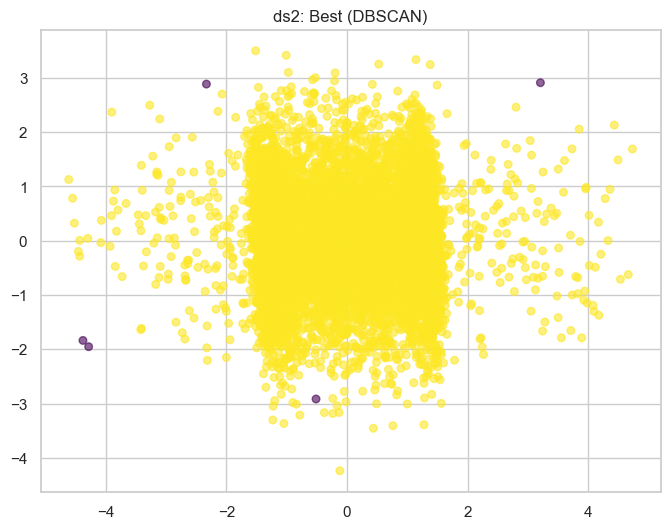


Processing ds3
✅ Loaded: S07-hw-dataset-03.csv (15000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB
None
--> Best KMeans: k=3, Sil=0.316
--> Best DBSCAN: eps=1.1, Sil=0.490


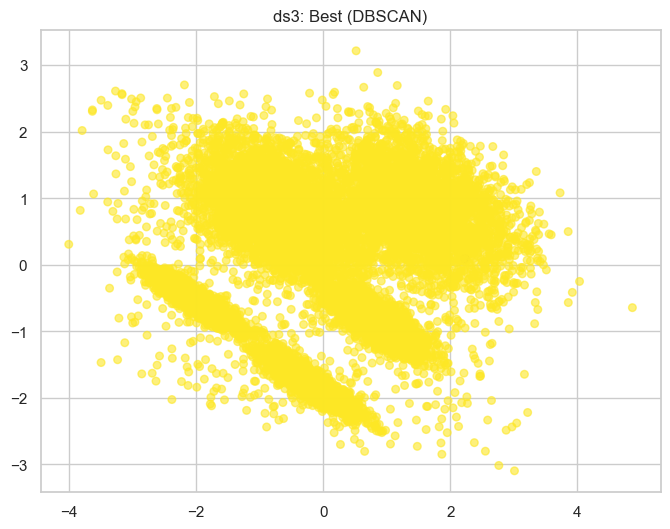


Processing ds4
✅ Loaded: S07-hw-dataset-04.csv (10000, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  10000 non-null  int64  
 1   cat_a      10000 non-null  object 
 2   cat_b      10000 non-null  object 
 3   n01        9826 non-null   float64
 4   n02        9811 non-null   float64
 5   n03        9801 non-null   float64
 6   n04        9808 non-null   float64
 7   n05        9799 non-null   float64
 8   n06        9817 non-null   float64
 9   n07        9796 non-null   float64
 10  n08        9806 non-null   float64
 11  n09        9805 non-null   float64
 12  n10        9811 non-null   float64
 13  n11        9796 non-null   float64
 14  n12        9798 non-null   float64
 15  n13        9803 non-null   float64
 16  n14        9802 non-null   float64
 17  n15        9814 non-null   float64
 18  n16        9809 non-null   

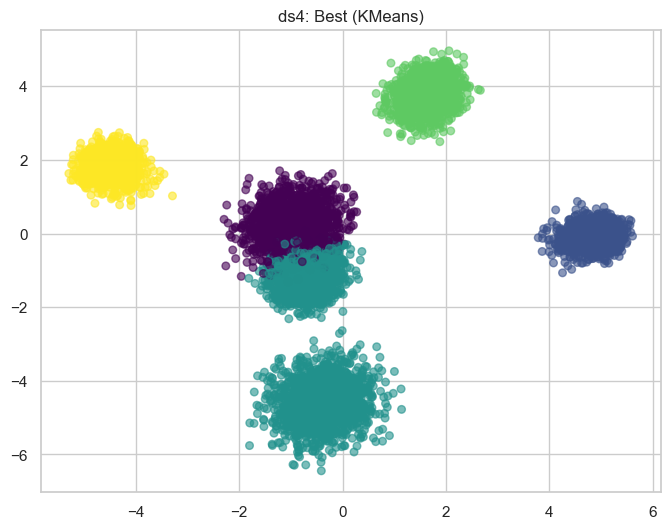

In [13]:
target_datasets = {
    'S07-hw-dataset-02.csv': 'ds2',
    'S07-hw-dataset-03.csv': 'ds3',
    'S07-hw-dataset-04.csv': 'ds4'
}

for fname, name in target_datasets.items():
    process_dataset(fname, name)

In [ ]:
print("\n Проверка устойчивости (Stability Check) для ds1")

fname = 'S07-hw-dataset-01.csv'
file_path = os.path.join(os.getcwd(), "data", fname)

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    if 'sample_id' in df.columns:
        X = df.drop(columns=['sample_id'])
    else:
        X = df
    X = StandardScaler().fit_transform(X)
    
    scores = []
    print("Запускаем KMeans 5 раз с разными random_state...")
    
    for seed in [1, 42, 100, 777, 999]:
        km = KMeans(n_clusters=3, n_init=10, random_state=seed)
        labels = km.fit_predict(X)
        score = silhouette_score(X, labels)
        scores.append(score)
        print(f"Seed {seed}: Silhouette = {score:.4f}")
        
    std_dev = np.std(scores)
    print(f"\nСтандартное отклонение (Std Dev): {std_dev:.5f}")
    
    if std_dev < 0.01:
        print("Результаты KMeans устойчивы (почти не меняются).")
    else:
        print("Вывод: Результаты варьируются.")
else:
    print(f"Файл '{fname}' не найден")


=== Проверка устойчивости (Stability Check) для ds1 ===
Файл 'S07-hw-dataset-01.csv' не найден


In [15]:
with open("artifacts/metrics_summary.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

with open("artifacts/best_configs.json", "w") as f:
    json.dump(best_configs, f, indent=4)

print("\n Сохранено в папку artifacts/")


 Сохранено в папку artifacts/
